Number of nonzeros: 199200 
Shape of the matrix: 40000 x 40000 
Format of the matrix: csr

MultilevelSolver
Number of Levels:     6
Operator Complexity:  1.336
Grid Complexity:      1.189
Coarse Solver:        'pinv'
  level   unknowns     nonzeros
     0       40000       199200 [74.87%]
     1        6700        59366 [22.31%]
     2         765         6633 [2.49%]
     3          90          774 [0.29%]
     4          12           84 [0.03%]
     5           2            4 [0.00%]

[[100 100 100 ... 100 100 100]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [ 20  20  20 ...  20  20  20]]
0.1586203917619176


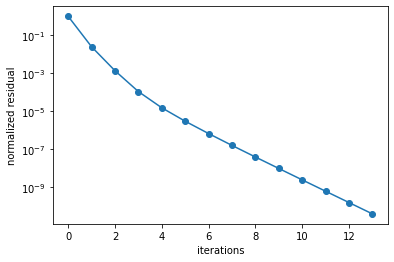

In [1]:
import scipy
import numpy
import pyamg
import matplotlib.pyplot as plt

width = 200
height = 200
#stencil = [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]
#stencil = [[0,-1,0],[-1,4,-1],[0,-1,0]]

stencil = [[0, 0, 0, 0, 1.0/560, 0, 0,0, 0],
           [0, 0, 0, 0, -8/315, 0, 0,0, 0],
           [0, 0, 0, 0, 1/5, 0, 0,0, 0],
           [0, 0, 0, 0, -8/5, 0, 0,0, 0],
           [1.0/560, -8/315, 1/5, -8/5, 205/72*2, -8/5, 1/5, -8/315, 1.0/560],
           [0, 0, 0, 0, -8/5, 0, 0,0, 0],
           [0, 0, 0, 0, 1/5, 0, 0,0, 0],
           [0, 0, 0, 0, -8/315, 0, 0,0, 0],
           [0, 0, 0, 0, 1.0/560, 0, 0,0, 0]]
stencil = [[0, 0, 1.0/12, 0, 0],
           [0, 0, -4.0/3, 0, 0],
           [1.0/12, -4.0/3, 5, -4.0/3, 1.0/12],
           [0 , 0, -4.0/3, 0, 0],
           [0 , 0, 1.0/12, 0, 0]]

stencil = [[0,-1,0],[-1,4,-1],[0,-1,0]]

A = pyamg.gallery.stencil_grid(stencil, (width, height), dtype=float, format='csr')

print(f'Number of nonzeros: {A.nnz} \n'
      f'Shape of the matrix: {A.shape[0]} x {A.shape[1]} \n'
      f'Format of the matrix: {A.format}\n')

B = numpy.ones((A.shape[0], 1))
ml = pyamg.smoothed_aggregation_solver(A, B, max_coarse=10)
print(ml)

residuals = []
#b = numpy.random.rand(A.shape[0])
b = numpy.full(A.shape[0], 0)
b = b.reshape((width,height))
b[:,0]=0#100.0/3 # Left
b[:,-1]=0#100.0/3 # Right
b=b.flatten()
b[:width]=100.0
b[-width:]=100.0/5
print(b.reshape((width,height)))
x0 = numpy.random.rand(A.shape[0])

x = ml.solve(b=b, x0=x0, tol=1e-10, residuals=residuals)
print((residuals[-1]/residuals[0])**(1.0/(len(residuals)-1)))

#x = ml.solve(b=b, x0=x0, tol=1e-10, residuals=residuals, accel='cg')
#print((residuals[-1]/residuals[0])**(1.0/(len(residuals)-1)))

plt.semilogy(residuals/residuals[0], 'o-')
plt.xlabel('iterations')
plt.ylabel('normalized residual')
plt.show()

In [2]:
x.reshape((width, height))[:,0]=0#100.0/3 # Left
x.reshape((width, height))[:,-1]=0 #100.0/3 # Right
x.reshape((width, height))[0, :] = 100.0
x.reshape((width, height))[-1,:] = 100.0/5

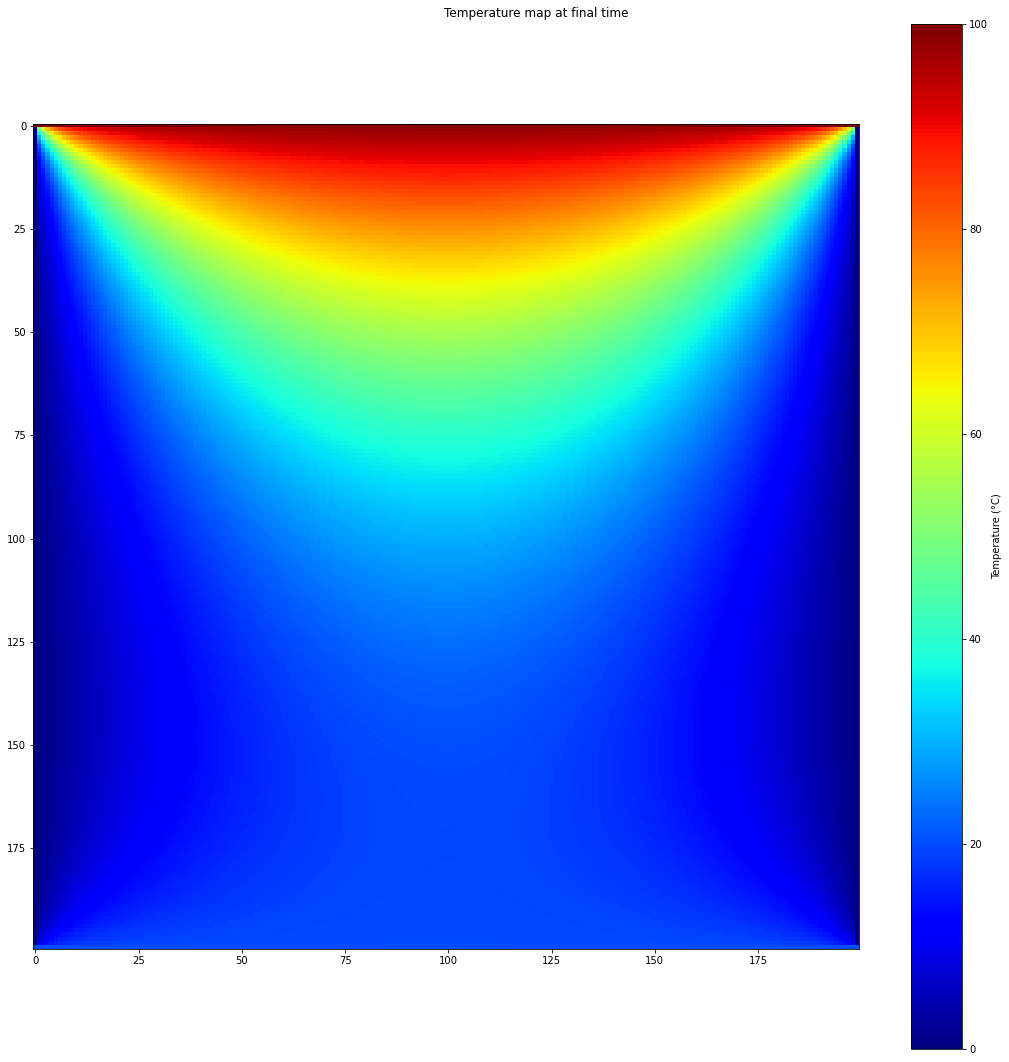

In [3]:
fig, ax = plt.subplots(figsize=(15,15))
mappable = ax.imshow(x.reshape((width, height)), interpolation=None, cmap=plt.cm.jet)
fig.colorbar(mappable, label="Temperature (°C)")
fig.suptitle("Temperature map at final time")
fig.tight_layout()

In [4]:
b = numpy.full(A.shape[0], 0)
b = b.reshape((width,height))
b[:,0]=0#100.0/3 # Left
b[:,-1]=0 #100.0/3 # Right
b=b.flatten()
b[:width]=100.0/5
b[-width:]=100
print(b.reshape((width,height)))

[[ 20  20  20 ...  20  20  20]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [100 100 100 ... 100 100 100]]


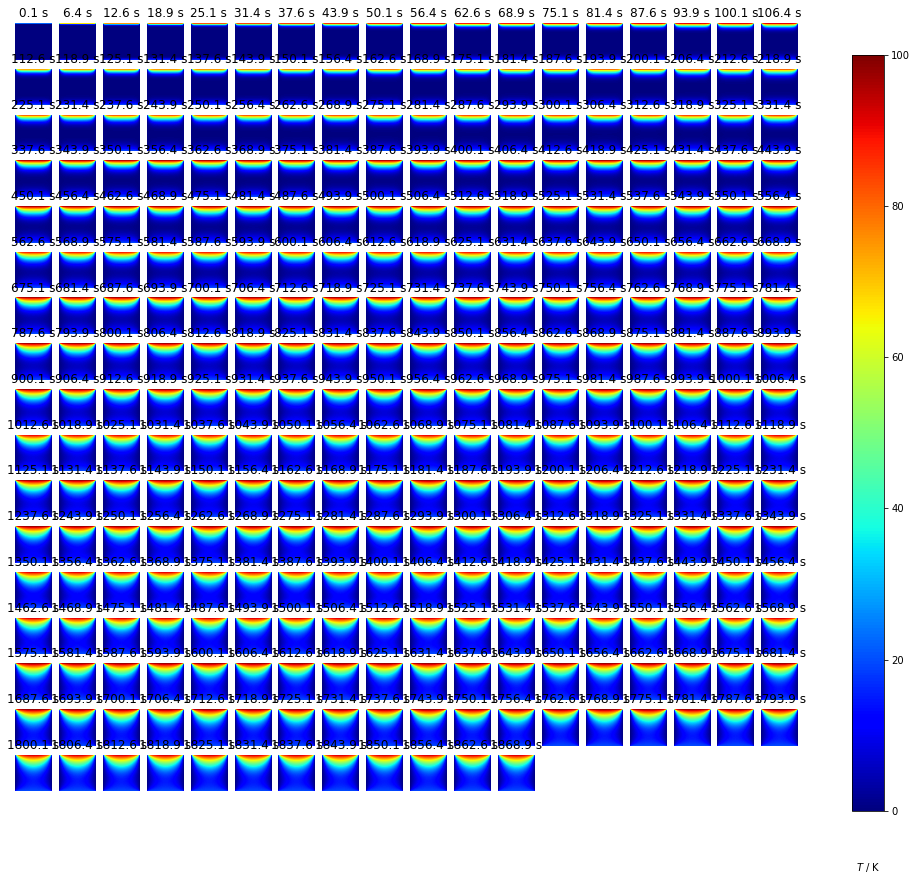

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
plate_length = 200
plate_width = 200
max_iter_time = 15000

alpha = 2
delta_x = 1

delta_t = (delta_x ** 2)/(4 * alpha)
gamma = (alpha * delta_t) / (delta_x ** 2)
Thot = 100.0
# Boundary conditions
u_top = Thot
u_left = 0
u_bottom = Thot/5
u_right = 0

# Initial condition everywhere inside the grid
u_initial = 0.0

def initialize_u(max_iter_time, ni=plate_length, nj=plate_width):
    
    # Initialize solution: the grid of u(k, i, j)
    u = np.full((max_iter_time, ni, nj), u_initial)

    # Set the boundary conditions
    u[:, 0, :] = u_top
    u[:, :, -1:1] = u_left
    u[:, -1, :] = u_bottom
    u[:, :, -1:1] = u_right
    return u
# original code to compute heatmap at each space and time step
'''def calculate(u):
    nk, ni, nj = u.shape
    for k in range(0, nk-1):
        for i in range(1, ni-1):
            for j in range(1, nj-1):
                u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]
    return u'''
def calculate(u):
    for k in range(0, max_iter_time-1, 1):
        for i in range(1, plate_length-1, delta_x):
            for j in range(1, plate_length-1, delta_x):
                u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]

    return u
#%time u1 = calculate(initialize_u(max_iter_time))

# using indexing approach
def calculate_even_faster(u):
    nk, ni, nj = u.shape
    for k in range(0, nk-1):
        A = u[k, 2:  , 1:-1]
        B = u[k,  :-2, 1:-1]
        C = u[k, 1:-1, 2:  ]
        D = u[k, 1:-1,  :-2]
        E = u[k, 1:-1, 1:-1]
        # set the newly computed heatmap at time k+1
        u[k+1, 1:-1, 1:-1] = gamma * (A+B+C+D-4*E) + E 
    return u

# create new map and display result
u3 = calculate_even_faster(initialize_u(max_iter_time))
#print(np.all(u3 == u1))
skip_factor = 50
def plotheatmap(u_k, k):
    # Clear the current plot figure
    plt.clf()

    plt.title(f"Temperature at t = {skip_factor*k*delta_t:.3f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.pcolormesh(u_k, cmap=plt.cm.jet, vmin=0, vmax=Thot)
    plt.colorbar()

    return plt

def animate(k):
    plotheatmap(u3[int(skip_factor*k)], k)

#anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=int(max_iter_time/skip_factor)-1, repeat=False)
#%time anim.save("vfast_heat_equation_solution.gif")

nsteps = max_iter_time
# Output 4 figures at these timesteps
mfig = list(range(1,nsteps ,skip_factor))
N = int(np.ceil(np.sqrt(len(mfig))))
fignum = 0
fig = plt.figure(figsize=(15,15))
for m in range(nsteps):
    if m in mfig:
        fignum += 1
        ax = fig.add_subplot(N,N,fignum)
        im = ax.imshow(u3[m], cmap=plt.cm.jet, vmin=0,vmax=Thot)
        ax.set_axis_off()
        ax.set_title('{:.1f} s'.format(m*delta_t))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('$T$ / K', labelpad=50)
fig.colorbar(im, cax=cbar_ax)
plt.show()
#https://towardsdatascience.com/300-times-faster-resolution-of-finite-difference-method-using-numpy-de28cdade4e1

In [6]:
np.round(u3[-1],1)

array([[100. , 100. , 100. , ..., 100. , 100. , 100. ],
       [  0. ,  50. ,  69.8, ...,  69.8,  50. ,   0. ],
       [  0. ,  30.2,  50. , ...,  50. ,  30.2,   0. ],
       ...,
       [  0. ,   6. ,  10. , ...,  10. ,   6. ,   0. ],
       [  0. ,  10. ,  14. , ...,  14. ,  10. ,   0. ],
       [ 20. ,  20. ,  20. , ...,  20. ,  20. ,  20. ]])

In [7]:
np.round(x.reshape((width, height)),1)

array([[100. , 100. , 100. , ..., 100. , 100. , 100. ],
       [  0. ,  50. ,  62.3, ...,  62.3,  50. ,   0. ],
       [  0. ,  37.7,  50. , ...,  50. ,  37.7,   0. ],
       ...,
       [  0. ,   7.5,  10. , ...,  10. ,   7.5,   0. ],
       [  0. ,  10. ,  12.5, ...,  12.5,  10. ,   0. ],
       [ 20. ,  20. ,  20. , ...,  20. ,  20. ,  20. ]])

In [8]:
np.round(u3[-1],1)-np.round(x.reshape((width, height)),1)

array([[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  7.5, ...,  7.5,  0. ,  0. ],
       [ 0. , -7.5,  0. , ...,  0. , -7.5,  0. ],
       ...,
       [ 0. , -1.5,  0. , ...,  0. , -1.5,  0. ],
       [ 0. ,  0. ,  1.5, ...,  1.5,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]])

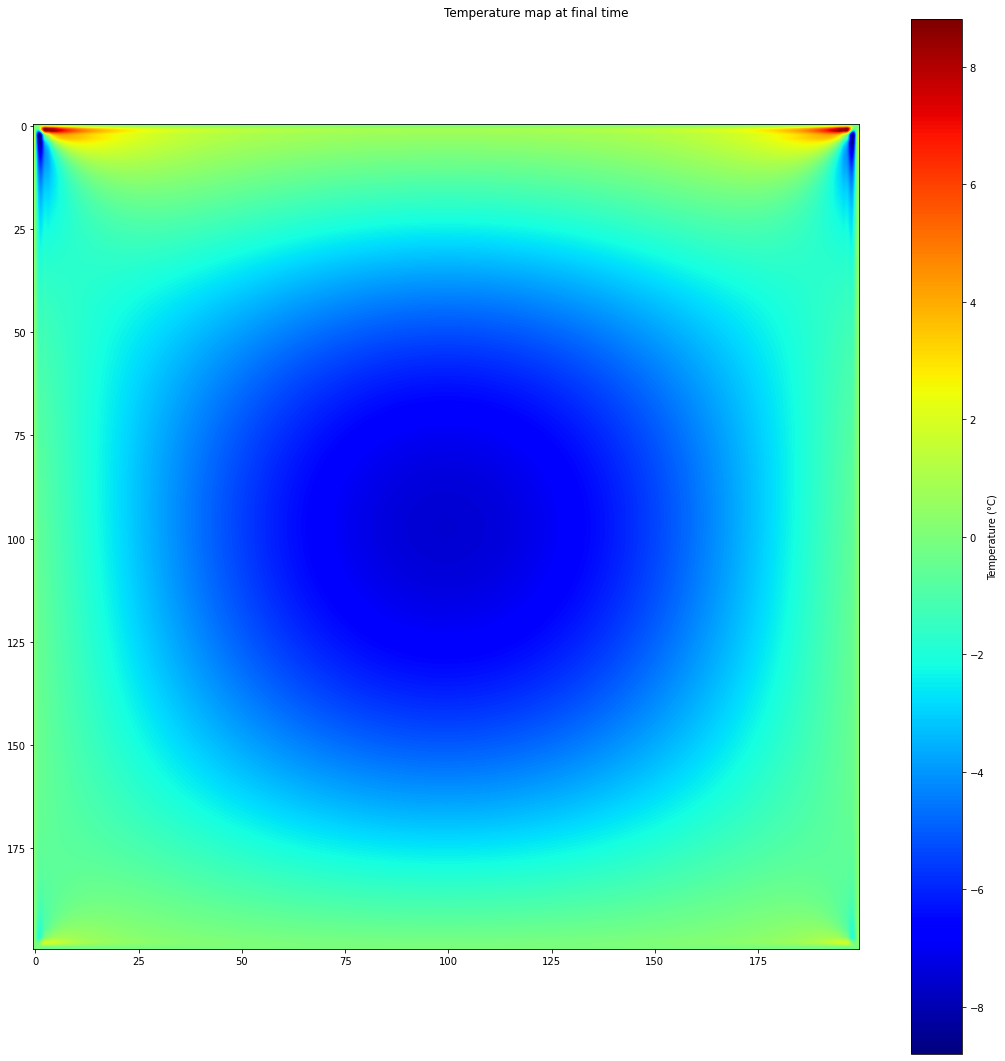

In [9]:
fig, ax = plt.subplots(figsize=(15,15))
mappable = ax.imshow(u3[-1]-x.reshape((width, height)), interpolation='lanczos', cmap=plt.cm.jet)
fig.colorbar(mappable, label="Temperature (°C)")
fig.suptitle("Temperature map at final time")
fig.tight_layout()

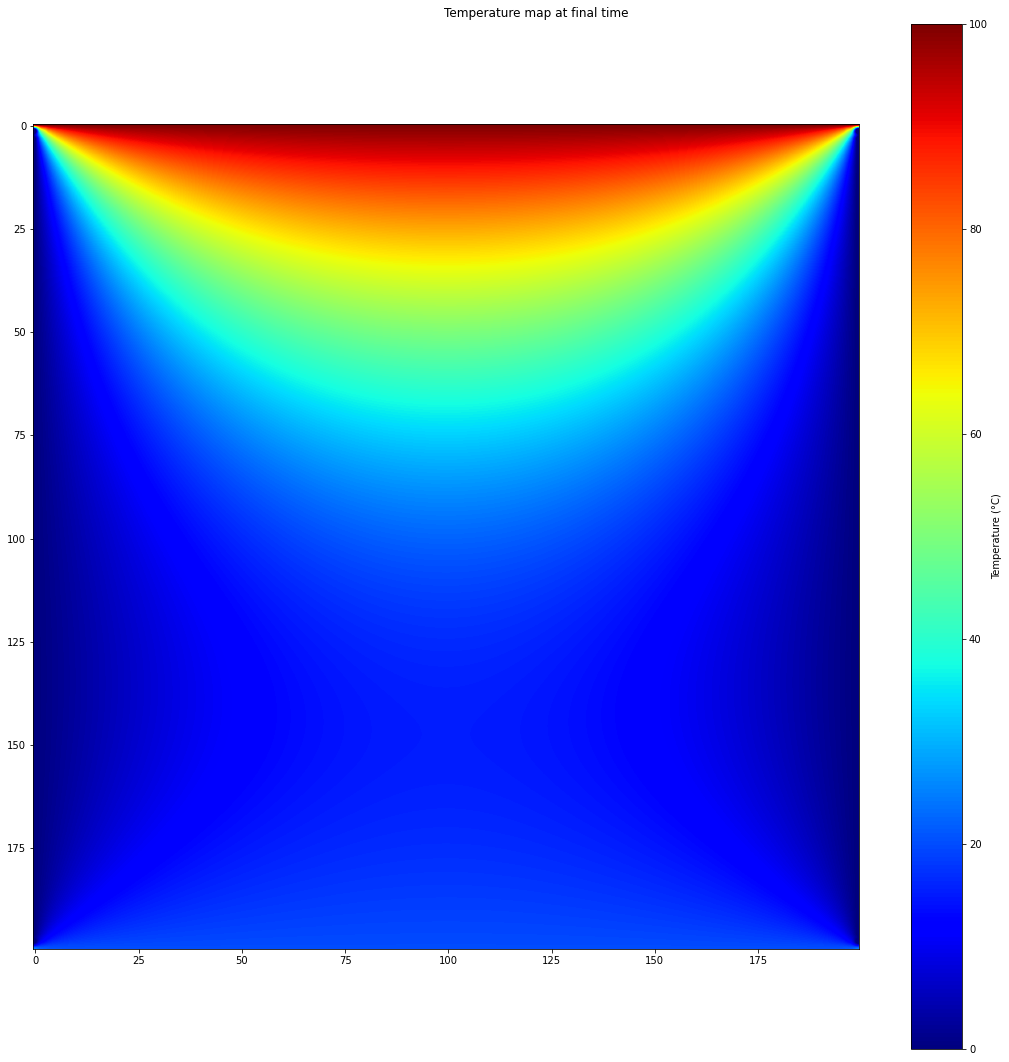

In [10]:
fig, ax = plt.subplots(figsize=(15,15))
mappable = ax.imshow(u3[-1], interpolation='lanczos', cmap=plt.cm.jet)
fig.colorbar(mappable, label="Temperature (°C)")
fig.suptitle("Temperature map at final time")
fig.tight_layout()

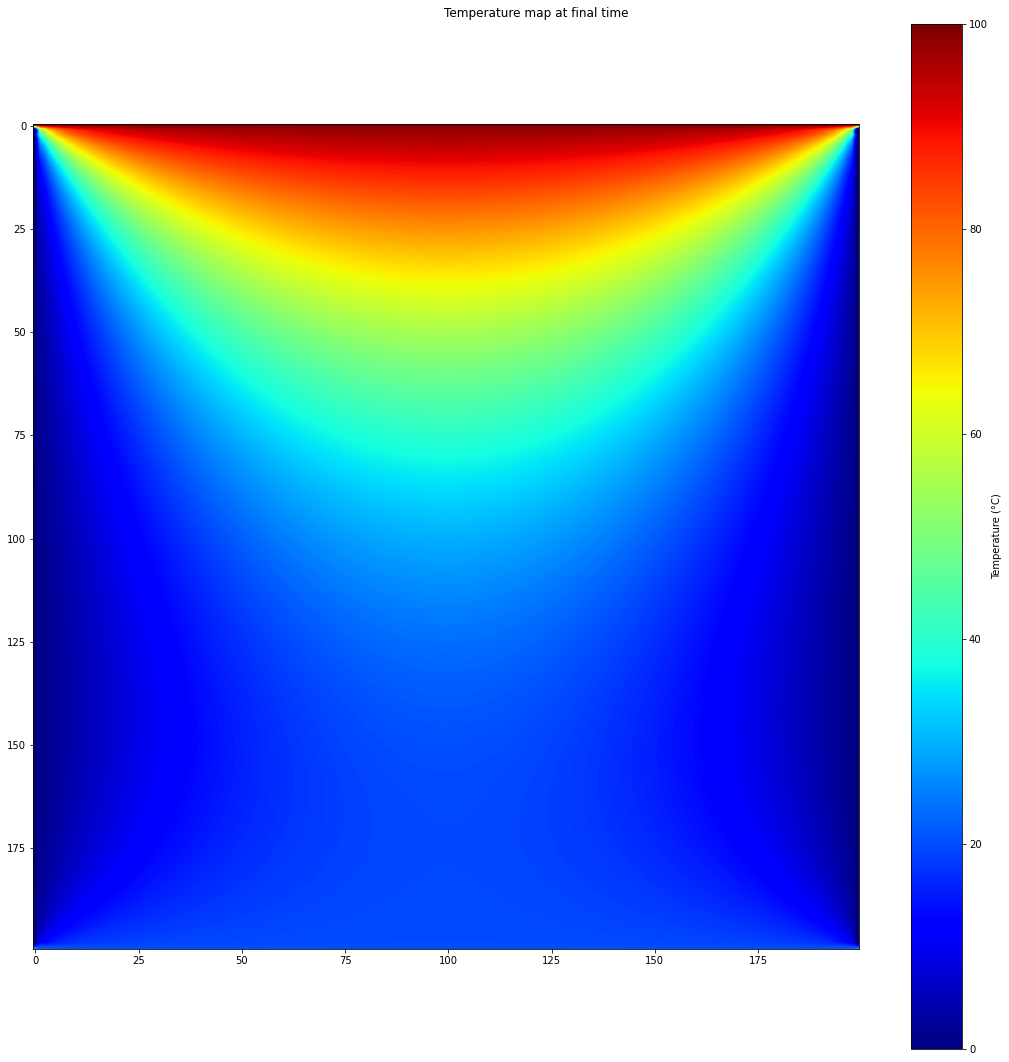

In [11]:
fig, ax = plt.subplots(figsize=(15,15))
mappable = ax.imshow(x.reshape((width, height)), interpolation='lanczos', cmap=plt.cm.jet)
fig.colorbar(mappable, label="Temperature (°C)")
fig.suptitle("Temperature map at final time")
fig.tight_layout()